In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D,Flatten,Dense,MaxPool2D,Dropout


In [1]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()



In [119]:
#for i in range(10):
#cv2.imwrite('1.jpg',x_test[])
lz = []
for i in range(len(y_test)):
    if y_test[i] == 9:
        lz.append(i)


In [120]:
s = 1
for i in lz:
    cv2.imwrite('%d.jpg'%s,x_test[i])
    s = s+1

    

8


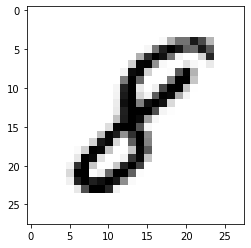

In [121]:

image_index = 7777 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')

In [122]:

def extract_plate(img): # the function detects and perfors blurring on the number plate.
	plate_img = img.copy()
	
	#Loads the data required for detecting the license plates from cascade classifier.
	plate_cascade = cv2.CascadeClassifier('C:/Users/Aaryan gupta/Downloads/Indian-license-plate-detection-master/AI-based-indian-license-plate-detection-master/indian_license_plate.xml')

	# detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
	plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

	for (x,y,w,h) in plate_rect:
		a,b = (int(0.023*img.shape[0]), int(0.005*img.shape[1])) #parameter tuning
		plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
		# finally representing the detected contours by drawing rectangles around the edges.
		cv2.rectangle(plate_img, (x-5,y), (x+w+b+10, y+h+a), (51,51,255), 3)
        
	return plate_img, plate # returning the processed image

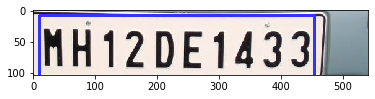

In [123]:
img = cv2.imread('C:/Users/Aaryan gupta/Downloads/ind_car3.jpg')
plate_img,plate = extract_plate(img)
plt.imshow(plate)

In [124]:
def img_process(img):
    imgc = img.copy()
    x,y,c = imgc.shape
    a,b = (int(0.02*imgc.shape[0]), int(0.025*imgc.shape[1])) #parameter tuning
    imgg = cv2.cvtColor(imgc,cv2.COLOR_BGR2GRAY)
    ret,thresh  = cv2.threshold(imgg,200,255,cv2.THRESH_BINARY_INV)
    kernel = np.ones((7,7)) / 7
    erode = cv2.erode(thresh,kernel)
    dilate = cv2.dilate(erode,kernel)
    
    dilate[0:b,:] = 255

    dilate[y-b:y,:] = 255
    dilate[:,0:a] = 255
    dilate[:,x-a:x] = 255
    
    lpw = dilate.shape[0]
    lph = dilate.shape[1]
    
    return dilate
    


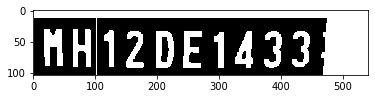

In [125]:
dilate = img_process(plate)
plt.imshow(dilate,cmap='gray')

In [126]:
def contourdetect(dilate,img):
    cntr,hierarchy = cv2.findContours(dilate,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    return hierarchy,cntr

In [127]:
hie,cntr = contourdetect(dilate,img)
hie

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 4,  1,  3, -1],
        [-1, -1, -1,  2],
        [ 5,  2, -1, -1],
        [ 7,  4,  6, -1],
        [-1, -1, -1,  5],
        [ 8,  5, -1, -1],
        [ 9,  7, -1, -1],
        [10,  8, -1, -1],
        [11,  9, -1, -1],
        [12, 10, -1, -1],
        [-1, 11, -1, -1]]], dtype=int32)

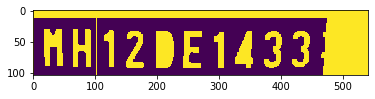

In [128]:
econt = {}
ext_cont = np.zeros(dilate.shape)
for i in range(len(cntr)):
    cv2.drawContours(ext_cont,cntr,i,255,-1)
    if hie[0][i][3] == -1:
        
        econt[i] = cntr
    
plt.imshow(ext_cont)
#display(econt)

In [129]:
dit = {}

def indi_num(econt,hie,plate,dit):
    k = 1
    x_cntr_list = []
    for i in cntr:
        intx,inty,intw,inth = cv2.boundingRect(i)
        x_cntr_list.append(intx)
        dit['%d'%k] = dilate[inty-10:inty+inth+10,intx-10:intx+intw+10]
        k = k+1

    indices = sorted(range(len(x_cntr_list)), key=lambda t: x_cntr_list[t])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(dit['%d'%(idx+1)])# stores character images according to their index
    img_res = np.array(img_res_copy)
    return img_res,k



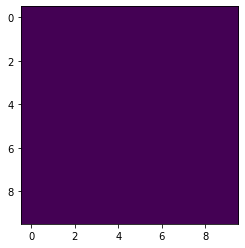

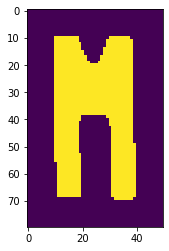

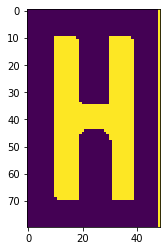

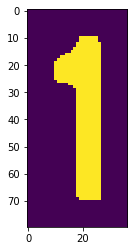

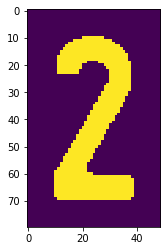

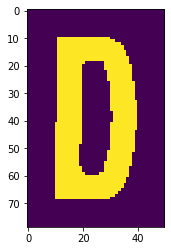

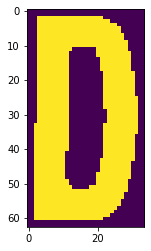

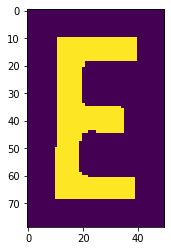

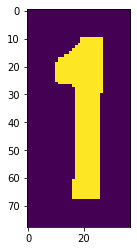

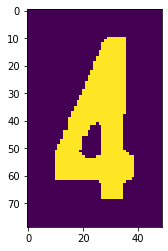

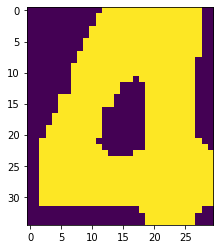

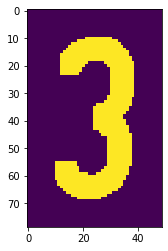

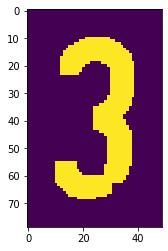

In [130]:
img_res,k = indi_num(econt,hie,plate,dit)
for i in range(k-1):
    plt.imshow(img_res[i])
    plt.show()


NameError: name 'findingcontours' is not defined

In [131]:

model = Sequential()
model.add(Conv2D(8, (4, 4),strides=(1,1),padding="same", activation='relu', input_shape=(75, 35, 3))),
model.add(MaxPool2D((8, 8),strides=(8,8),padding="same"))
model.add(Conv2D(16, (2, 2), activation='relu'))
model.add(MaxPool2D((4, 4),strides=(4,4),padding="same"))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36,activation='softmax'))

In [132]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 75, 35, 8)         392       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 5, 8)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 4, 16)          528       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 1, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               6272      
_________________________________________________________________
dense_8 (Dense)              (None, 36)               

In [133]:

#display(x_train.shape)


#train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.05, height_shift_range=0.05)

#train_generator = train_datagen.flow_from_directory(
#        'C:/Users/Aaryan gupta/Downloads/data_indian_license_plate/data/train',  # this is the target directory
#        target_size=(75,35),  # all images will be resized to 28x28
#        batch_size=4,
#        class_mode='categorical')
#
#validation_generator = train_datagen.flow_from_directory(
#        'C:/Users/Aaryan gupta/Downloads/data_indian_license_plate/data/val',  # this is the target directory
#        target_size=(75,35),  # all images will be resized to 28x28
#        batch_size=4,
#        class_mode='categorical')
#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#display(type(train_generator))

(60000, 28, 28)

Found 58953 images belonging to 36 classes.
Found 10216 images belonging to 36 classes.


keras.preprocessing.image.DirectoryIterator

In [134]:
#batch_size = 30
#model.fit_generator(train_generator,
#      steps_per_epoch = train_generator.samples // batch_size,
#      validation_data = validation_generator, 
#      validation_steps = validation_generator.samples // batch_size,
#      epochs = 10)

Epoch 1/10
1965/1965 [==============================] - 139s 71ms/step - loss: 0.0483 - accuracy: 0.9825 - val_loss: 0.0412 - val_accuracy: 0.9893
Epoch 2/10
1965/1965 [==============================] - 114s 58ms/step - loss: 0.0271 - accuracy: 0.9897 - val_loss: 0.0507 - val_accuracy: 0.9884
Epoch 3/10
1965/1965 [==============================] - 115s 58ms/step - loss: 0.0222 - accuracy: 0.9913 - val_loss: 0.0126 - val_accuracy: 0.9930
Epoch 4/10
1965/1965 [==============================] - 111s 57ms/step - loss: 0.0194 - accuracy: 0.9923 - val_loss: 0.0334 - val_accuracy: 0.9932
Epoch 5/10
1965/1965 [==============================] - 103s 52ms/step - loss: 0.0187 - accuracy: 0.9928 - val_loss: 8.2089e-04 - val_accuracy: 0.9924
Epoch 6/10
1965/1965 [==============================] - 102s 52ms/step - loss: 0.0167 - accuracy: 0.9934 - val_loss: 0.0301 - val_accuracy: 0.9915
Epoch 7/10
1965/1965 [==============================] - 104s 53ms/step - loss: 0.0157 - accuracy: 0.9939 - val_los

In [20]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    #img = cv2.resize(img,(35,75))
    for i in range(3):
        new_img[:,:,i] = img
    
    #plt.imshow(new_img)
    #plt.show()
    new_img = np.expand_dims(new_img,axis=0)
    return new_img


train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

#display(type()))

In [21]:
x_n_train = []
for i in range(x_train.shape[0]):
    x_n_train.append(fix_dimension(x_train[i]))
    

In [29]:
#display((x_n_train[0][0][0][0][0]))

0.0

In [23]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(x_n_train,y_train,BATCH_SIZE, epochs=10)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 60000 arrays: [array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],...

In [135]:
model.save('num_plate_detect1.h5')

In [145]:
nmodel = load_model('num_plate_detect1.h5')

def fix_dimension(img):
    new_img = np.zeros((75,35,3))
    img = cv2.resize(img,(35,75))
    for i in range(3):
        new_img[:,:,i] = img
    
    plt.imshow(new_img)
    plt.show()
    new_img = np.expand_dims(new_img,axis=0)
    return new_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


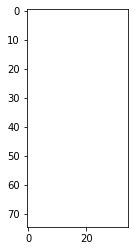

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


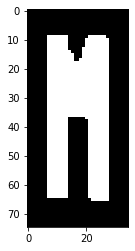

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


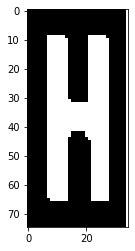

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


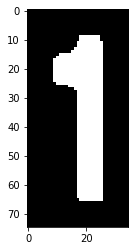

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


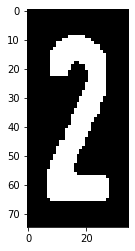

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


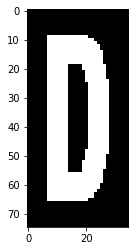

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


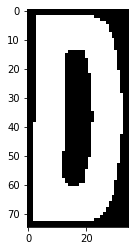

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


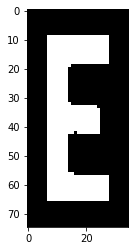

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


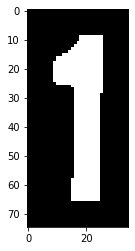

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


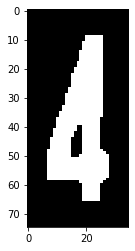

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


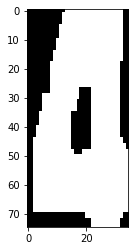

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


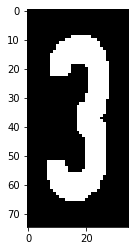

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


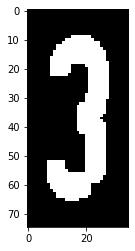

In [146]:
rsdit = {}
for i in range(k-1):
    rsdit['%d'%(i+1)] = fix_dimension(img_res[i])

    
#img = cv2.resize(dit['1'],(75,35))
#plt.imshow(img)


#test1 = dit['4']
#test1.shape
#test1.size
#np.resize(test1,(28,28))

#test1n = test1.reshape((28,28))
#nimg = fix_dimension(test1)
#plt.imshow(nimg)

In [147]:
#test1 = rsdit['4']
#model.predict_classes(test1)
str = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
refdit = {}
platenum = []
for i in range(len(str)):
    refdit['%d'%(i)] = str[i]
    
display(refdit)
# testing the model for the image
for i in rsdit:
    test = model.predict_classes(rsdit[i])
    display(test)
    test = test.reshape((1,1))
    for j in refdit:
        
        if( int(j) == test):
            platenum.append(refdit[j])
            
display(platenum)

{'0': '0',
 '1': '1',
 '2': '2',
 '3': '3',
 '4': '4',
 '5': '5',
 '6': '6',
 '7': '7',
 '8': '8',
 '9': '9',
 '10': 'A',
 '11': 'B',
 '12': 'C',
 '13': 'D',
 '14': 'E',
 '15': 'F',
 '16': 'G',
 '17': 'H',
 '18': 'I',
 '19': 'J',
 '20': 'K',
 '21': 'L',
 '22': 'M',
 '23': 'N',
 '24': 'O',
 '25': 'P',
 '26': 'Q',
 '27': 'R',
 '28': 'S',
 '29': 'T',
 '30': 'U',
 '31': 'V',
 '32': 'W',
 '33': 'X',
 '34': 'Y',
 '35': 'Z'}

array([11], dtype=int64)

array([33], dtype=int64)

array([17], dtype=int64)

array([3], dtype=int64)

array([3], dtype=int64)

array([13], dtype=int64)

array([11], dtype=int64)

array([5], dtype=int64)

array([3], dtype=int64)

array([8], dtype=int64)

array([10], dtype=int64)

array([3], dtype=int64)

array([3], dtype=int64)

['B', 'X', 'H', '3', '3', 'D', 'B', '5', '3', '8', 'A', '3', '3']

### def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,ch in enumerate(characters):
        img1 = cv2.resize(ch,(28,28))
        img = dim(img1)
        img = img.reshape(1,28,28,3)
        y1 = model.predict_classes(img)[0]
        character = dic[y1]
        output.append(character)
    
    plate_number = ''.join(output)
    return plate_number

print(show_results())

In [345]:
j = '33'
g = int(j[1])
display(g)
d = np.ones((1,1,1))
if d == 1:
    display(5)


3

5